### Random Forest
* Ensemble 알고리즘?  
기본 모델을 여러 개 사용해서 하나의 예측을 만들어내는 것  

RF는 결정 트리 기반의 앙상블 알고리즘  

1995년 랜덤 피처 - 2001년 랜덤 피처 + 랜덤 샘플(bagging)  
결정 트리의 Overfitting 문제, 높은 variance 문제를 해결  
01년 논문에서는 다수의 선택을 따랐으나 최근에는 확률의 평균을 산출해서 결정

### Gradient Boosting Machine, GBM
* GBM and Deep Learning  
Tabular data(table 형태의 데이터)에서는 GBM이 가장 좋은 성능, 그 외의 경우 Deep Learning 활용  

1997년 Boosting을 이용한 손실 함수 최적화 - 1999년 실제 알고리즘화  
Boosting: 여러 결정트리를 활용하되, 이전 트리의 오차를 줄이는 방향으로 **순차적** 학습  
개별 결정트리의 bais를 효과적으로 감소시켜 성능 향상

Q. Bias(실제 에러) vs Variance(분산, 평균으로부터 벗어난 정도)?  
대표적인 tool은 XGBoost(11-12년) and LightGBM(17년)  

더 자세한 내용은 [블로그 포스트](https://bcho.tistory.com/1354) 참고


In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
from google.colab import files
files.upload()

Saving dku_data.zip to dku_data.zip


In [5]:
!unzip dku_data.zip

Archive:  dku_data.zip
   creating: build/
   creating: build/feature/
  inflating: build/feature/feature.csv  
   creating: build/sub/
   creating: data/
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [6]:
!ls

build  data  dku_data.zip  sample_data


In [7]:
data_dir = Path('./data')
feature_dir = Path('./build/feature')
sub_dir = Path('./build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

### Loading Feature Data

In [8]:
feature_name = 'feature'
feature_file = feature_dir / f'{feature_name}.csv'

In [9]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [10]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000]
tst = df.iloc[320000:]
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [11]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(256000, 19) (64000, 19) (256000,) (64000,)


### Running Random Forest

* n_estimator  
몇 개의 결정 트리를 학습해서 조합할 것인가  
* min_samples_leaf  
각 결정 트리의 leaf node 최소 수  
* max_features  
random feature를 선택할 때 최대 몇 개, 'auto'를 주면 sqrt(#features)까지 사용  
* max_samples  
random data를 sampling할 때 최대 몇 퍼센트까지 사용할 것인가  
* random_state  
reproduce를 위해서 일정한 값 사용  

In [23]:
algo_name = 'rf'
model_name = f'{algo_name}_{feature_name}'
sub_file = sub_dir / f'{model_name}.csv' 

In [27]:
clf = RandomForestClassifier(n_estimators=100,
                             min_samples_leaf=10,
                             max_features='auto',
                             max_samples=.5,
                             random_state=seed,
                             n_jobs=-1)
clf.fit(X_trn, y_trn)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

### Validate and Visualize Feature Importance
개별 트리를 시각화해서 feature 중요도 확인은 어려움  
전체를 합산해서 보는 편이 용이함

In [28]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

92.4531%


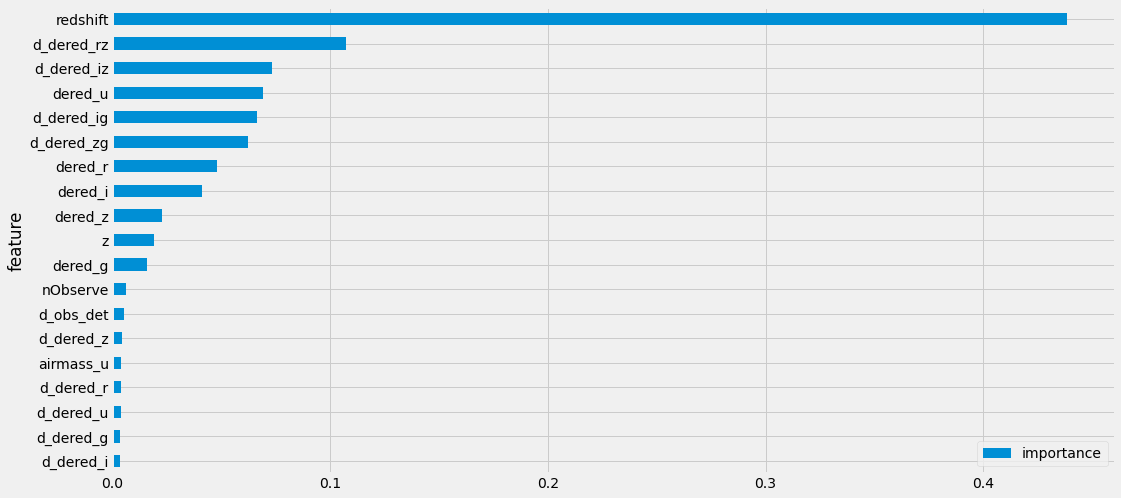

In [29]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Running LightGBM
* objective  
회귀, 분류(binary, multiclass) 등 학습의 목표를 지정
* learning_rate(shrinkage)  
직전 decision tree의 error에 곱해주는 값  
이 값이 크면 osciallation이 생길 수 있고, 작으면 더 많은 tree와 학습 시간이 필요함  
* subsample_freq  
개별트리 학습시에 subsampling을 얼마 마다 하는가 e.g. 1 = 매번, 10 = 10번에 한 번  
* colsample_bytree  
개별트리 학습시에 전체 col 중 몇 퍼센트를 사용하는가  
* LGBMClassifier, LGBMRegresser  

fit시에 추가로 parameter를 줄 수 있음
* eval_set  
validation set을 주고 각 epoch마다 손실함수를 확인할 수 있음  
* early_stopping_rounds  
손실함수가 더 이상 향상되지 않는 시점을 확인 e.g. 10번 도는 동안 개선이 없을 경우, early stop -> 과적합 방지  

In [30]:
algo_name = 'lgb'
model_name = f'{algo_name}_features' # {feature_name} 사용하면 파일명이 지나치게 길어져 제출시 에러 발생
sub_file = sub_dir / f'{model_name}.csv'

In [31]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's multi_logloss: 0.889466
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.809411
[3]	valid_0's multi_logloss: 0.737205
[4]	valid_0's multi_logloss: 0.67578
[5]	valid_0's multi_logloss: 0.622648
[6]	valid_0's multi_logloss: 0.58102
[7]	valid_0's multi_logloss: 0.541851
[8]	valid_0's multi_logloss: 0.509749
[9]	valid_0's multi_logloss: 0.48277
[10]	valid_0's multi_logloss: 0.453402
[11]	valid_0's multi_logloss: 0.427857
[12]	valid_0's multi_logloss: 0.404554
[13]	valid_0's multi_logloss: 0.383858
[14]	valid_0's multi_logloss: 0.364991
[15]	valid_0's multi_logloss: 0.348485
[16]	valid_0's multi_logloss: 0.334275
[17]	valid_0's multi_logloss: 0.321026
[18]	valid_0's multi_logloss: 0.308562
[19]	valid_0's multi_logloss: 0.297153
[20]	valid_0's multi_logloss: 0.287213
[21]	valid_0's multi_logloss: 0.277694
[22]	valid_0's multi_logloss: 0.268968
[23]	valid_0's multi_logloss: 0.261297
[24]	valid_0's multi_logloss: 0.254532
[25]	valid_0's

In [32]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

92.9359%


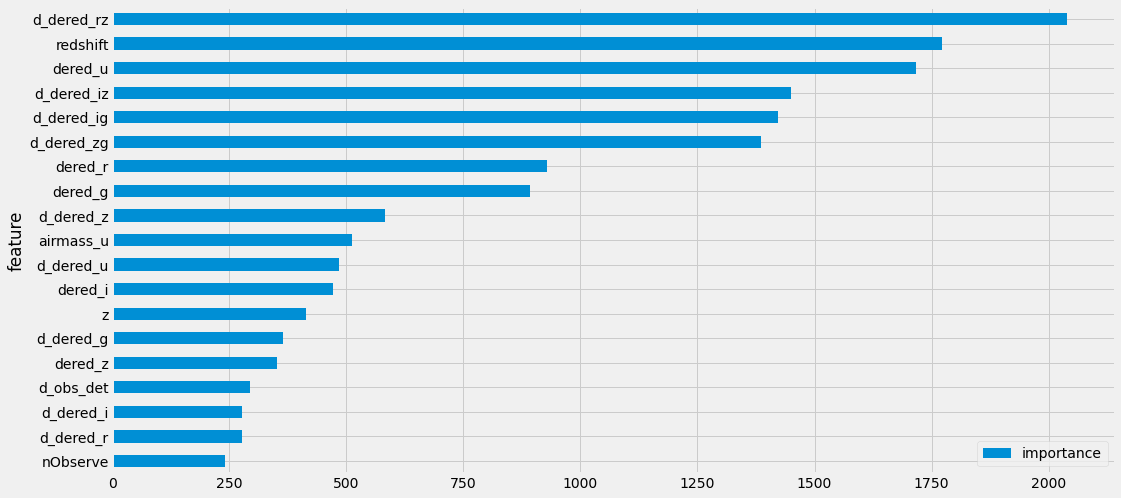

In [33]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Download for Submission

In [34]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [35]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [36]:
sub[target_col].value_counts()

2.0    41353
0.0    29982
1.0     8665
Name: class, dtype: int64

In [37]:
sub.to_csv(sub_file)

In [39]:
files.download(sub_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>